In [35]:
'''This script demonstrates how to build a variational autoencoder with Keras.

 KL-Divergence
 
'''
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from tensorflow.keras.layers import Input, Dense, Lambda, Layer
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics

from scipy.optimize import fmin
from scipy.stats import entropy
from scipy.stats import norm
import sys


# show the network
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot


------------ Sanity check start -------------
Calculate KL divergence between uni-modal distributions.
Numeric values should be somehow equal to the analytic values!
KLD left vs. middle (numeric): 4.499999999998725
KLD right vs. middle (numeric): 4.499999999998716
KLD left vs. middle (analytic): 4.5
KLD right vs. middle (analytic): 4.5
------------ Sanity check end -------------

A DK-minimization approach that samples either N_1 or N_2 will try to put theresulting N into the middle of both distributions, because it does not see any relationbetween these distributionsThis is because the KL defined on single Gaussian does only cover one Gaussian at a time,Therefore, it is obvious that the minimum resulting N has mu=0.5(mu_1 + mu_2) and std = sqrt(std_1^2 + std_2^2)

mu_mid, mu_left, mu_right, std_mid, std_left, std_right: 0.0, -3.0, 3.0, 0.5, 1.0, 1.0
1. KLD joint vs. middle (sum of single KLD, i.e. optimized by the NN): 9.63629436111989
2. KLD joint vs. middle (numeric and corrent KLD 

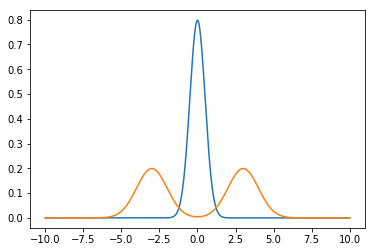

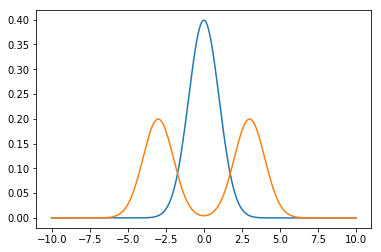

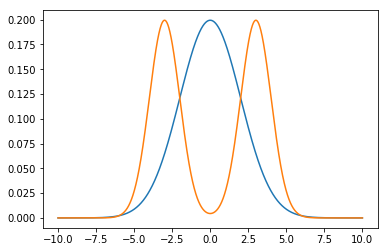

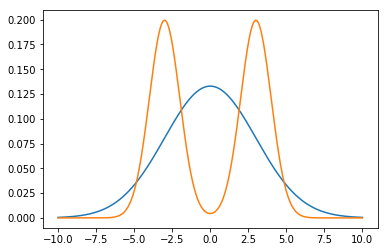

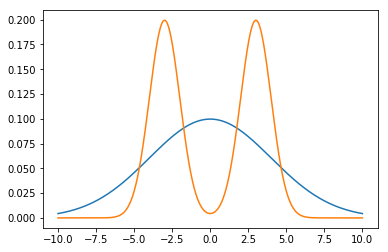

In [36]:
def dkl_gauss(mu1, std1, mu2, std2):
    # DKL(N(mu1, std1)||N(mu2, std2)) 
    return np.log(std2) - np.log(std1) + std1**2 / (2 * std2**2) + (mu1 - mu2)**2 / (2 * std2**2) - 1/2

def dkl_gauss_opt(mu_std, mu1, std1):
    # returns DKL(N(mu_std)||N(mu1, std1))
    return dkl_gauss(mu_std[0], mu_std[1], mu1, std1)

def dkl_gauss_opt2(mu_std, mu1, std1, mu2, std2):
    # returns the sum DKL(N(mu_std)||N(mu1, std1)) + DKL(N(mu_std)||N(mu2, std2))
    return dkl_gauss(mu_std[0], mu_std[1], mu1, std1) + dkl_gauss(mu_std[0], mu_std[1], mu2, std2)

def norm_multi(x, pdf):
    # returns normalized PDF of all scipy continues random variable (rv_continuous) PDF functions in the list pdf
    r = np.zeros(pdf[0].pdf(x).shape)
    for f in pdf:
        r += f.pdf(x)
    return r / np.float(len(pdf))

def entropy_sanity(pk, qk):
    # Calculate KL divergence between the ground-truth pk and approximator qk
    # remove zero values because it causes divide by zero errors: https://datascience.stackexchange.com/questions/11320/kl-divergence-returns-infinity
    pk[pk <= sys.float_info.min] = sys.float_info.min
    qk[qk <= sys.float_info.min] = sys.float_info.min
    return entropy(pk = pk, qk = qk)


def entropy_opt(mu_std, qk, x):
    # returns DKL(N(mu_std)||qk)
    rv = norm(loc = mu_std[0], scale = mu_std[1])
    return entropy_sanity(pk = rv.pdf(x), qk = qk)


# def entropy_opt2(mu_std, mu1 = mu1, std1 = std1, mu2 = mu2, std2 = std2):

#initialize a normal distribution with frozen in mean=-1, std. dev.= 1
rv = norm(loc = 0., scale = 1.0)
rv1 = norm(loc = -3., scale = 1.0)
rv2 = norm(loc = 3., scale = 1.0)
x = np.arange(-10, 10, .001)

# plot the pdfs of these normal distributions 
#plt.plot(x, rv.pdf(x), x, norm_multi(x, [rv1, rv2]))
#plt.show()

print("------------ Sanity check start -------------")
print("Calculate KL divergence between uni-modal distributions.")
print("Numeric values should be somehow equal to the analytic values!")
# numeric
dkl_num_LvsM = entropy_sanity(pk = rv.pdf(x), qk = rv1.pdf(x))
dkl_num_RvsM = entropy_sanity(pk = rv.pdf(x), qk = rv2.pdf(x))
print("KLD left vs. middle (numeric): " + str(dkl_num_LvsM))
print("KLD right vs. middle (numeric): " + str(dkl_num_RvsM))
# analytic
print("KLD left vs. middle (analytic): " + str(dkl_gauss_opt([rv.mean(), rv.std()], mu1 = rv1.mean(), std1 = rv1.std())))
print("KLD right vs. middle (analytic): " + str(dkl_gauss_opt([rv.mean(), rv.std()], mu1 = rv1.mean(), std1 = rv2.std())))
print("------------ Sanity check end -------------")
print("")

print("A DK-minimization approach that samples either N_1 or N_2 will try to put the" +
    "resulting N into the middle of both distributions, because it does not see any relation" +
    "between these distributions" +
    "This is because the KL defined on single Gaussian does only cover one Gaussian at a time," +
    "Therefore, it is obvious that the minimum resulting N has mu=0.5(mu_1 + mu_2) and std = sqrt(std_1^2 + std_2^2)")
print("")

def KLD_eval(rv, rv1, rv2):
    print("mu_mid, mu_left, mu_right, std_mid, std_left, std_right: "
          + str(rv.mean()) + ", " + str(rv1.mean()) + ", " + str(rv2.mean()) + ", "
          + str(rv.std()) + ", " + str(rv1.std()) + ", " + str(rv2.std()))
    print("1. KLD joint vs. middle (sum of single KLD, i.e. optimized by the NN): " + str(dkl_gauss_opt2([rv.mean(), rv.std()], mu1 = rv1.mean(), std1 = rv1.std(),mu2 = rv2.mean(), std2 = rv2.std())))
    print("2. KLD joint vs. middle (numeric and corrent KLD between joint and middle PDF): " + str(entropy_sanity(pk = rv.pdf(x), qk = norm_multi(x, [rv1, rv2]))))
    #plot the pdfs of these normal distributions 
    plt.plot(x, rv.pdf(x), x, norm_multi(x, [rv1, rv2]))
    plt.show()
    print("")

rv = norm(loc = 0., scale = .5)
KLD_eval(rv, rv1, rv2)
rv = norm(loc = 0., scale = 1.0)
KLD_eval(rv, rv1, rv2)
rv = norm(loc = 0., scale = 2.0)
KLD_eval(rv, rv1, rv2)
rv = norm(loc = 0., scale = 3.0)
KLD_eval(rv, rv1, rv2)
rv = norm(loc = 0., scale = 4.0)
KLD_eval(rv, rv1, rv2)

print("It can be seen, that both error functions (not metrics) are convex but" + 
      " at different points of the standard deviation. The KLD of the full joint" + 
      " dstiribution tries tends to have a minima where the overlapping is the highest" + 
      " whilst the disjunct approach only matches the variance quantity and average mean.")


In [37]:
# Sanity Check: Single Gaussian optimization

# Inital seed
mu_init = 1
std_init = 1.2
x0 = [mu_init, std_init]
# Target parameters
mu1 = 0.
std1 = 1.

xOpt = fmin(dkl_gauss_opt, x0, args=(mu1, std1,))
print("Befor Optimization: " + str(dkl_gauss_opt(x0, mu1 = mu1, std1 = std1)))
print("After Optimization: " + str(dkl_gauss_opt(xOpt, mu1 = mu1, std1 = std1)))
print("mu: " + str(round(xOpt[0],2)) + ", std: " + str(round(xOpt[1],2)))

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 37
         Function evaluations: 73
Befor Optimization: 0.5376784432060453
After Optimization: 5.775406819452655e-10
mu: -0.0, std: 1.0


In [38]:
# Multi Gaussian optimization (as it would be done by NN)

# Inital seed
mu_init = 1
var_init = 1.2
x0 = [mu_init, var_init]
# Target parameters
mu1 = 1.
std1 = 1.
mu2 = -1.
std2 = 1.

#mu1 = 10.
#std1 = 1.
#mu2 = -10.
#std2 = 2.


xOpt = fmin(dkl_gauss_opt2, x0, args=(mu1, std1, mu2, std2,))
print("Befor Optimization: " + str(dkl_gauss_opt2(x0, mu1 = mu1, std1 = std1, mu2 = mu2, std2 = std2)))
print("After Optimization: " + str(dkl_gauss_opt2(xOpt, mu1 = mu1, std1 = std1, mu2 = mu2, std2 = std2)))
print("mu: " + str(round(xOpt[0],2)) + ", std: " + str(round(xOpt[1],2)))

Optimization terminated successfully.
         Current function value: 1.000000
         Iterations: 37
         Function evaluations: 73
Befor Optimization: 2.0753568864120906
After Optimization: 1.0000000011550814
mu: -0.0, std: 1.0


In [39]:
# Mixture of Gaussian optimization

# Inital seed
mu_init = 1
var_init = 1.2
x0 = [mu_init, var_init]
# Target parameters
mu1 = 1.
var1 = 1.
mu2 = -1.
var2 = 1.

pdf_joint = norm_multi(x, [norm(loc = mu1, scale = std1), norm(loc = mu2, scale = std2)])
x = np.arange(-10, 10, .001)
xOpt = fmin(entropy_opt, x0, args=(pdf_joint, x,))

# Print
rv = norm(loc = x0[0], scale = x0[1])
print("Befor Optimization: " + str(entropy_sanity(pk = rv.pdf(x), qk = pdf_joint)))
rv = norm(loc = xOpt[0], scale = xOpt[1])
print("After Optimization: " + str(entropy_sanity(pk = rv.pdf(x), qk = pdf_joint)))
print("mu: " + str(round(xOpt[0],2)) + ", std: " + str(round(xOpt[1],2)))


Optimization terminated successfully.
         Current function value: 0.010888
         Iterations: 39
         Function evaluations: 75
Befor Optimization: 0.27810299151520357
After Optimization: 0.010887864188974963
mu: -0.0, std: 1.39


In [85]:
batch_size = 100
input_dim_dummy = 1 # const.
latent_dim_1 = 16
latent_dim_2 = 16
latent_dim_samp = 1
epochs = 50

def sampling(args):
    mu, log_var = args
    epsilon = K.random_normal(shape=(K.shape(mu)[0], latent_dim_samp), mean=0., stddev=1.)
    return mu + K.sqrt(K.exp(log_var)) * epsilon

def get_model():
    mean_target = Input(shape=(latent_dim_samp,), name="input_mean_target")
    log_var_target = Input(shape=(latent_dim_samp,), name="input_log_var_target")
    x = Input(shape=(input_dim_dummy,), name="input_dummy")
    h1 = Dense(latent_dim_1, activation='relu', name="latent1")(x)
    h2 = Dense(latent_dim_2, activation='relu', name="latent2")(h1)
    mean = Dense(latent_dim_samp, name="mean")(h2)
    log_var = Dense(latent_dim_samp, name="log_var")(h2)
    
    # note that "output_shape" isn't necessary with the TensorFlow backend
    sample        = Lambda(sampling, output_shape=(latent_dim_samp,), name="sample")([mean, log_var])
    sample_target = Lambda(sampling, output_shape=(latent_dim_samp,), name="sample_target")([mean_target, log_var_target])
    return sample, sample_target, mean_target, log_var_target, mean, log_var, x

# Custom loss layer with KL and MSE loss
class CustomVariationalReconstructLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalReconstructLayer, self).__init__(**kwargs)

    def kl_loss(self, mean1, log_var1, mean2, log_var2):
        #return self.kl_loss_std(mean1, K.sqrt(K.exp(log_var1)), mean2, K.sqrt(K.exp(log_var2)))
        return K.sum(- .5 * (1 + log_var1 - log_var2 - ((K.exp(log_var1) + K.square(mean1 - mean2)) / K.exp(log_var2))), axis=-1)

    def kl_loss_std(self, mean_target, std_target, mean, std):
        return K.sum(- .5 * (1  + K.log(std) - K.log(std_target) - (K.square(std) + K.square(mean - mean_target)) / (K.square(std_target))), axis=-1)

    def loss(self, sample, sample_target, mean_target, log_var_target, mean, log_var):
        #mse_loss = latent_dim_samp * metrics.mean_squared_error(sample, sample_target)
        mse_loss = 1 / (1+ K.abs(sample))
        return K.mean(mse_loss + self.kl_loss(mean_target, log_var_target, mean, log_var))

    def call(self, inputs):
        sample = inputs[0]
        sample_target = inputs[1]
        mean_target = inputs[2]
        log_var_target = inputs[3]
        mean = inputs[4]
        log_var = inputs[5]
        loss = self.loss(sample, sample_target, mean_target, log_var_target, mean, log_var)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return sample # loss

# Custom loss layer with KL loss only
class CustomVariationalLayer(CustomVariationalReconstructLayer):
    def __init__(self, **kwargs):
        super(CustomVariationalLayer, self).__init__(**kwargs)
        
    def loss(self, sample, sample_target, mean_target, log_var_target, mean, log_var):
        return K.mean(self.kl_loss(mean_target, log_var_target, mean, log_var))


In [86]:
# Define training data
num = 5000
mean_target_noise_std = 0.01
mean_targets_gt = np.array([-10., 10.])

std_target_noise_std = 0.01
std_targets_gt = np.array([1., 1.])

target_choice = np.random.choice(np.int32([0, 1]), size=(num,))
mean_targets_samples = mean_targets_gt[target_choice] + mean_target_noise_std * np.random.standard_normal(size=(num,))
std_target_samples = std_targets_gt[target_choice] + std_target_noise_std * (np.random.rand(num) - 0.5)
#dummy = np.random.rand(num)
dummy = np.zeros((num,))

In [87]:
print(mean_targets_gt[target_choice])

[ 10.  10.  10. ...  10.  10. -10.]


In [88]:
mean_target = Input(shape=(latent_dim_samp,), name="input_mean_target")
log_var_target = Input(shape=(latent_dim_samp,), name="input_log_var_target")
x = Input(shape=(input_dim_dummy,), name="input_dummy")
h1 = Dense(latent_dim_1, activation='relu', name="latent1")(x)
h2 = Dense(latent_dim_2, activation='relu', name="latent2")(h1)
mean = Dense(latent_dim_samp, name="mean")(h2)
log_var = Dense(latent_dim_samp, name="log_var")(h2)

# note that "output_shape" isn't necessary with the TensorFlow backend
sample        = Lambda(sampling, output_shape=(latent_dim_samp,), name="sample")([mean, log_var])
sample_target = Lambda(sampling, output_shape=(latent_dim_samp,), name="sample_target")([mean_target, log_var_target])

    
#sample, sample_target, mean_target, log_var_target, mean, log_var, x = get_model()
y_kl = CustomVariationalLayer()([sample, sample_target, mean_target, log_var_target, mean, log_var])
model_kl = Model([mean_target, log_var_target, x], y_kl)
model_kl.compile(optimizer='adam', loss=None)

SVG(model_to_dot(model_kl).create(prog='dot', format='svg'))

# train the model
model_kl.fit(x = [mean_targets_samples, np.log(std_target_samples**2), dummy],
            y = None,
            shuffle=True,
            epochs=epochs,
            batch_size=batch_size,
            verbose=2)

Train on 5000 samples
Epoch 1/50
5000/5000 - 1s - loss: nan
Epoch 2/50
5000/5000 - 0s - loss: nan
Epoch 3/50
5000/5000 - 0s - loss: nan
Epoch 4/50
5000/5000 - 0s - loss: nan
Epoch 5/50
5000/5000 - 0s - loss: nan
Epoch 6/50
5000/5000 - 0s - loss: nan
Epoch 7/50
5000/5000 - 0s - loss: nan
Epoch 8/50
5000/5000 - 0s - loss: nan
Epoch 9/50
5000/5000 - 0s - loss: nan
Epoch 10/50
5000/5000 - 0s - loss: nan
Epoch 11/50
5000/5000 - 0s - loss: nan
Epoch 12/50
5000/5000 - 0s - loss: nan
Epoch 13/50
5000/5000 - 0s - loss: nan
Epoch 14/50
5000/5000 - 0s - loss: nan
Epoch 15/50
5000/5000 - 0s - loss: nan
Epoch 16/50
5000/5000 - 0s - loss: nan
Epoch 17/50
5000/5000 - 0s - loss: nan
Epoch 18/50
5000/5000 - 0s - loss: nan
Epoch 19/50
5000/5000 - 0s - loss: nan
Epoch 20/50
5000/5000 - 0s - loss: nan
Epoch 21/50
5000/5000 - 0s - loss: nan
Epoch 22/50
5000/5000 - 0s - loss: nan
Epoch 23/50
5000/5000 - 0s - loss: nan
Epoch 24/50
5000/5000 - 0s - loss: nan
Epoch 25/50
5000/5000 - 0s - loss: nan
Epoch 26/50


In [62]:
# plot trained mean and std
estimation_kl = Model(x, [mean, log_var])
prediction = estimation_kl.predict(np.array([0.]))
mean_estimated_kl, log_var_estimated_kl = prediction[0], prediction[1]
print("mean_estimated: " + str(mean_estimated_kl))
print("std_estimated: " + str(np.exp(log_var_estimated_kl)**.5))
# SVG(model_to_dot(estimation).create(prog='dot', format='svg'))

mean_estimated: [[0.01478053]]
std_estimated: [[1.4142488]]


In [46]:
sample, sample_target, mean_target, log_var_target, mean, log_var, x = get_model()
y_kle = CustomVariationalReconstructLayer()([sample, sample_target, mean_target, log_var_target, mean, log_var])
model_kle = Model([mean_target, log_var_target, x], y_kle)
model_kle.compile(optimizer='adam', loss=None)

# train the model
model_kle.fit(x = [mean_targets_samples, np.log(std_target_samples**2), dummy],
            y = None,
            shuffle=True,
            epochs=epochs,
            batch_size=batch_size,
            verbose=0)

In [47]:
estimation_kle = Model(x, [mean, log_var])
prediction = estimation_kle.predict(np.array([0.]))
mean_estimated_kle, log_var_estimated_kle = prediction[0], prediction[1]
print("mean_estimated: " + str(mean_estimated_kle))
print("std_estimated: " + str(np.exp(log_var_estimated_kle)**.5))
# SVG(model_to_dot(estimation).create(prog='dot', format='svg'))

mean_estimated: [[0.01759442]]
std_estimated: [[0.8981244]]
